In [ ]:
%matplotlib inline

## Audio Processing, Video Processing and Computer Vision
## Bachelor in Data Science and Engineering - Universidad Carlos III de Madrid

# LAB SESSION 4: IMAGE CLASSIFICATION WITH CNNs

# AUTOMATIC DIAGNOSTIC SYSTEM OF SKIN LESIONS FROM DERMOSCOPIC IMAGES


### Iván González Díaz, Miguel Ángel Fernández Torres


<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>

In this practice we are going to build a skin lesion diagnosis system based on dermoscopic image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Our goal is to develop a CNN providing an automatic diagnosis of cutaneous diseases from dermoscopic images. Dermoscopy is a non-invasive technique that allows the evaluation of the colors and microstructures of the epidermis, the dermoepidermal joint and the papillary dermis that are not visible to the naked eye. These structures are specifically correlated with histological properties of the lesions. Identifying specific visual patterns related to color distribution or dermoscopic structures can help dermatologists decide the malignancy of a pigmented lesion. The use of this technique provides a great help to the experts to support their diagnosis. However, the complexity of its analysis limits its application to experienced clinicians or dermatologists.

In our scenario, we will consider 3 classes of skin lesions:

- Malignant melanoma: Melanoma, also known as malignant melanoma, is the most common type of cancer, and arises from pigmented cells known as melanocytes. Melanomas typically occur on the skin and rarely elsewhere such as the mouth, intestines, or eye.

- Seborrheic keratosis: it is a noncancerous (benign) tumor of the skin that originates from the cells of the outer layer of the skin (keranocytes), so it is a non-melanocytic lesion.

- Benign nevus: a benign skin tumor caused by melanocytes (it is melanocytic)

Figure 1 shows a visual example of the 3 considered lesions:

![Image of ISIC](https://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

The dataset has been obtained from the 'Internatial Skin Imaging Collaboration' (ISIC) file. It contains 2750 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 150 images
- Test set: 600 images

For each clinical case, two images are available:
- The dermoscopic image of the lesion (in the ‘images’ folder).
- A binary mask with the segmentation between injury (mole) and skin (in the 'masks' folder)

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image and mask.
- the lesion label: available only for training and validation, being an integer between 0 and 2: 0: benign nevus, 1: malignant melanoma, 2: seborrheic keratosis. In the case of the test set, labels are not available (their value is -1).

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Design a feedforward CNN that processess images and provides a diagnostic
- 2) Use a regular network that has been pretrained using a large-scale general purpose dataset and fine-tune it for our diagnostic problem

## Part 1: Handling our custom dataset with PyTorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The first thing we need to do is to download and decompress the dataset on a local folder:




In [3]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')
#copyfile('/content/drive/My Drive/LS4_AVCV_DB.zip', './LS4_AVCV_DB.zip') #Copy db files to our working folder

Mounted at /content/drive


In [4]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
import zipfile
zipPath='/content/drive/MyDrive/Audio Processing/LS4_AVCV_DB.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 4-digit sequence, adding 0 to the left side if required)
- Label: 0 benign nevus, 1 melanoma, 2 seborrheic keratosis



In [5]:
db = pd.read_csv('data/LS4_AVCV_DB/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

#We show inform
n = 65
img_id = db.id[65]
label = db.label[65]


print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))


Image ID: 0066
Label: 0


Now, let's create a simple function to show an image.




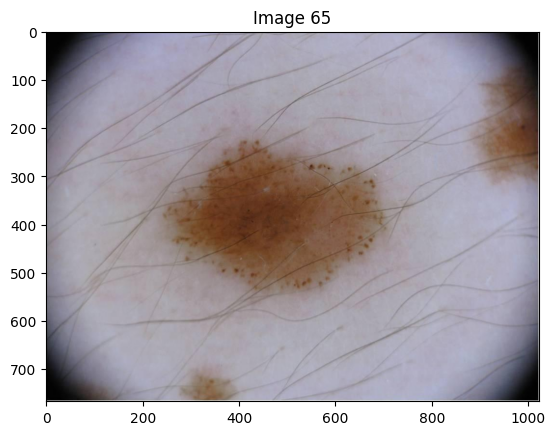

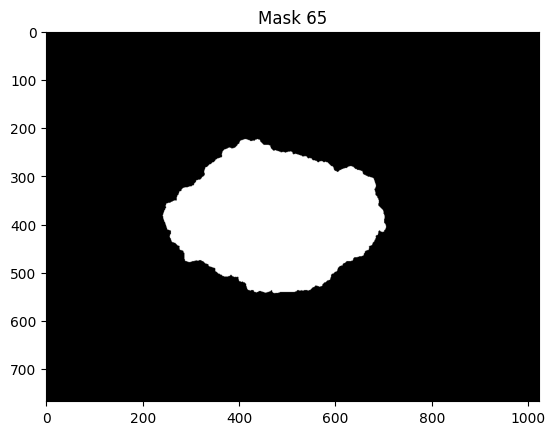

In [6]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)

plt.figure()
imshow(io.imread(os.path.join('data/LS4_AVCV_DB/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/LS4_AVCV_DB/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset is going to be a dictionary `` {'image': image, 'mask': mask, 'label': label} ``. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [7]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,  maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})

        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)

        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.long)}
        if self.transform:
            sample = self.transform(sample)
        return sample

We now instantiate the class to iterate over some samples to see what we generate.


0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


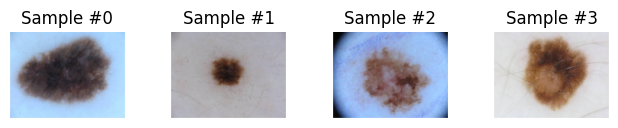

In [8]:
train_dataset = DermoscopyDataset(csv_file='data/LS4_AVCV_DB/dermoscopyDBtrain.csv',
                                    root_dir='data/LS4_AVCV_DB')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

**IMPORTANT**

The optional parameter ``maxSize`` in the constructor allows us to subsample the number of images and consequently reduce the size of the dataset. If not set included or maxSize=0, then the dataset will include all the images. This parameter is useful to train models over smaller datasets during hyperparameter validation and design phases. Working with less images reduces the training time at the expense of obtaining results that may deviate from those obtained with the full dataset size. Of course, the larger the training dataset, the more stable results but the larger the training time. Hence, it is up to the students the use of this parameter.

### Data Pre-Processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:

- ``CropByMask``: to crop the image using the lesion mask
- ``Rescale``: to scale the image
- ``RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
- ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- ``ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [9]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Compute the coordinates of the bounding box that contains the mask
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}

class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size.
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0

        if w>new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}

class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)

        return {'image':image,
                'mask':mask,
                'label':label}

class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means.
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):

        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same'
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])


        return {'image': image, 'mask': mask, 'label' : label}

### Exercise:

Use the following code to apply the previous transforms and experiment with the values of the parameters to study their influence. Read the documentation at the begining of each class to understand the sintaxis of the input parameters.



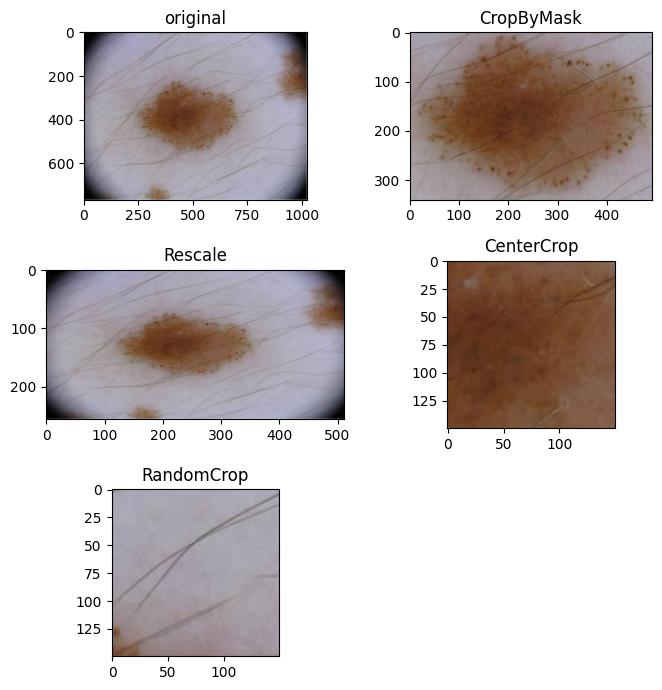

In [10]:
# Amount of skin around the lesion; parameters are the 'y' and 'x' pixels
cmask = CropByMask((5, 15))

# Recales the image; parameters are the new height and width
scale = Rescale((256, 512))

# Data augmentation; the parameter is the size of the output, in this case: 150 pixels x 150 pixels
rcrop = RandomCrop(150)

# Crops at the center; the parameter is again the size of the output
ccrop = CenterCrop(150)

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(7,7))
sample = train_dataset[65]
ax = plt.subplot(3,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

for i, tsfrm in enumerate([cmask, scale, ccrop, rcrop]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(3, 2, i+2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

We see that RandomCrop provides little benefit in this medical context.
Since the lesions are already centered and framed using CropByMask, applying a random crop often removes part of the lesion.
This reduces the amount of diagnostic information, which can make RandomCrop not useful and sometimes counterproductive.

#### Using package torchvision.transforms

Package torchvision.trasforms comes with many useful methods that implement valuable transforms for data augmentation. Those transforms can be applied either to torch.tensors or to images. However, torchvision uses PIL library to read and process images, in contrast to the matrix representation of images used in scikit-image library (the library we have used in the previous methods). Furthermore, some of the transforms affect both to input images and skin-lesion masks, which avoid applying them to our samples. Hence, in order to use a torchvision transform we need to implement a pipeline that:

- 1) First, convert the matrix-based images to PILImages
- 2) Apply the transform to PILImages
- 3) Convert PILImages to matrices

And applies these to input images and, if necessary, to the binary skin-lesion masks. The following class ``TVCenterCrop`` implements the same functionality as the previous ``CenterCrop``, but using the corresponding method in torchvision. It is therefore a useful example if you plan to make use of torchvision transforms.


In [11]:
class TVCenterCrop(object):
    """Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC=transforms.CenterCrop(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CC(pil_image)
        image=util.img_as_float(np.asarray(pil_image))

        pil_mask=Image.fromarray(util.img_as_ubyte(mask))
        pil_mask=self.CC(pil_mask)
        mask=util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

Now, we apply to transform to check the results

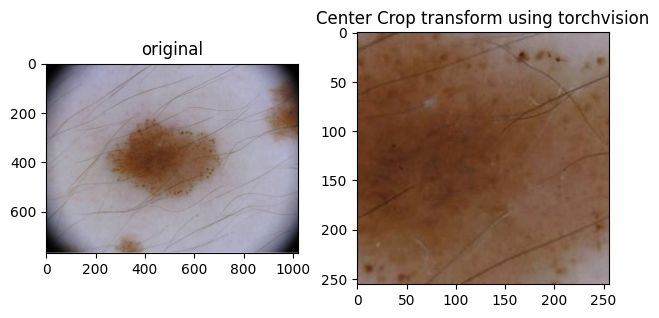

In [12]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVCenterCrop(256)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise

Implement other transforms using torchvision package. Take TVCenterCrop as guide.


In [13]:
from torchvision.transforms import functional as F, InterpolationMode

class TVRescale(object):
    """
    Re-scale image and mask using Resize from torchvision.

    Args:
        size (int or tuple):
            - int: resize so the shorter side == size
            - (H, W): resize to exact height & width
    """

    def __init__(self, size):
        self.size = size
        # Define interpolation modes

        # Bilinear because the image is a continuous signal and we want the new version to look smooth
        self.image_interp = InterpolationMode.BILINEAR

        # Nearest neighbour as the mask is categorical (values can only be 0 or 1)
        self.mask_interp = InterpolationMode.NEAREST

        # Resize transforms
        self.resize_image = transforms.Resize(size, interpolation=self.image_interp)
        self.resize_mask = transforms.Resize(size, interpolation=self.mask_interp)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']

        # We convert from Numpy to PIL images
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        # We apply the previous Resize transform to both
        pil_image = self.resize_image(pil_image)
        pil_mask  = self.resize_mask(pil_mask)

        # We convert back from PIL to Numpy
        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))

        # We return the sample once it is already transformed
        return {'image': image, 'mask': mask, 'label': label}

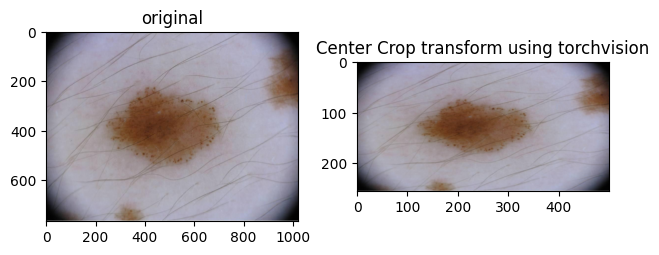

In [14]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVRescale((256, 500))

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

In [15]:
class TVCropByMask(object):
    """
    Crop the image using the lesion mask, using torchvision-style functional API.

    Args:
        border (tuple or int):
            - If int: same vertical & horizontal margin
            - If tuple: (y margin, x margin)
    """

    def __init__(self, border):
        if isinstance(border, int):
            self.border = (border, border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        h, w = image.shape[:2]

        # Convert to PIL
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        # We find the (row (y), column (x)) coordinates of all non-zero pixels in the mask.
        # These correspond to the lesion area, and will be used to compute the bounding box for cropping.
        lesion_area = np.nonzero(mask)

        # We expand by the specified border
        # We introduce the mask function in case the lesion is near an edge, for avoiding going outside the image
        minx = max(lesion_area[1].min() - self.border[1], 0)
        miny = max(lesion_area[0].min() - self.border[0], 0)

        # The same as before but now with the min function
        maxx = min(lesion_area[1].max() + 1 + self.border[1], w)
        maxy = min(lesion_area[0].max() + 1 + self.border[0], h)

        # We apply the same crop to image and mask
        pil_image = F.crop(pil_image, top=miny, left=minx, height=maxy-miny, width=maxx-minx)
        pil_mask  = F.crop(pil_mask , top=miny, left=minx, height=maxy-miny, width=maxx-minx)

        # We convert back to numpy
        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

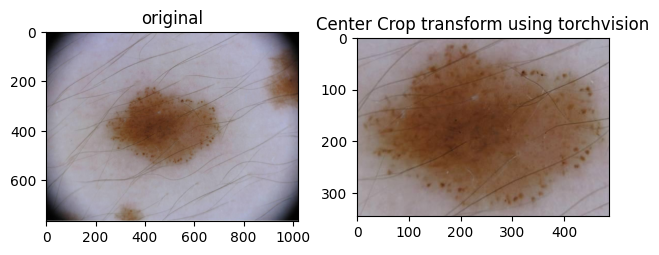

In [16]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVCropByMask((12, 12))

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

In [17]:
class TVRandomCrop(object):
    """
    Randomly crop the image and mask using torchvision.

    Args:
        size (int or tuple): crop size. If int, square crop.
    """

    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']

        # We convert to PIL
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        # We get crop parameters once and apply to both
        t, l, h, w = transforms.RandomCrop.get_params(pil_image, output_size=self.size)
        pil_image = F.crop(pil_image, top=t, left=l, height=h, width=w)
        pil_mask  = F.crop(pil_mask , top=t, left=l, height=h, width=w)

        # We convert back to NumPy
        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

TypeError: cannot unpack non-iterable int object

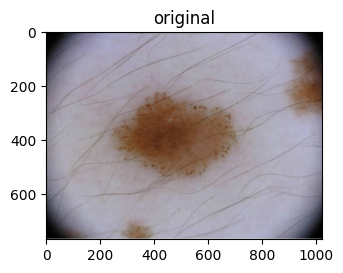

In [20]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVRandomCrop(256)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

In [21]:
class TVToTensor(object):
    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        label = torch.tensor(label, dtype=torch.long)
        return {'image': image, 'mask': mask, 'label': label}


In [22]:
class TVNormalize(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        image = self.normalize(image)
        return {'image': image, 'mask': mask, 'label': label}


### Composed Transforms

Now let's apply the different transformations to our images.

We will rescale the images so that their smallest dimension is 224 and then make random crops of size 224. To compose the transformations ``Rescale`` and ``RandomCrop`` we can use ``torchvision.transforms.Compose``, which is a simple callable class.


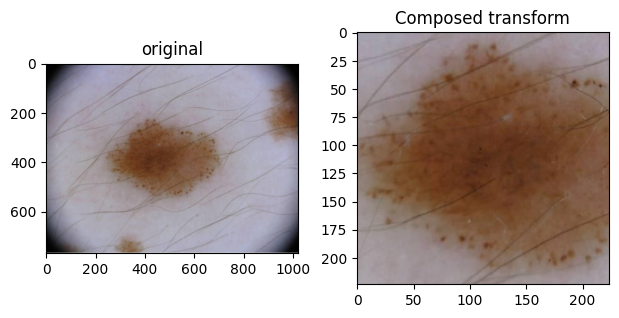

In [23]:
composed = transforms.Compose([CropByMask(15), Rescale(224),RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise:

Use the previous code to test different combinations of transform and discuss the results.

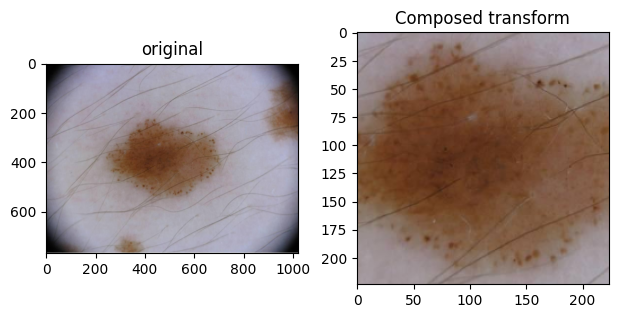

In [24]:
composed = transforms.Compose([CropByMask(15), Rescale(224), CenterCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

The difference here is that the same crop will be returned every time (the center)

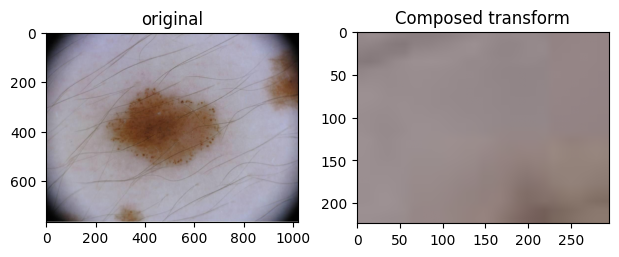

In [25]:
composed = transforms.Compose([RandomCrop(224), CropByMask(15), Rescale(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

We see here that randomly cropping the image prior applying the CropByMask may lead to losing most part of the lesion.

In addition, when the RandomCrop outputs an image where no lesion pixels are found, an error arises when applying CropByMask, as it could be expected.

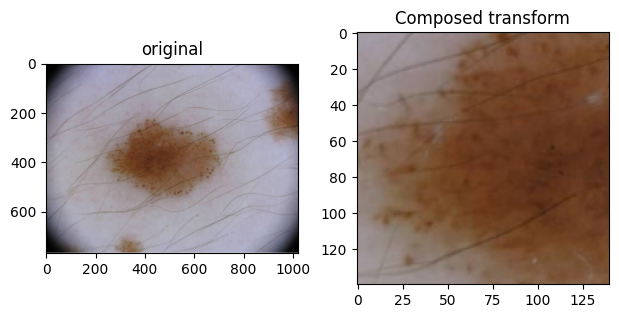

In [26]:
composed = transforms.Compose([CropByMask(15), RandomCrop(224), Rescale(140)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

By applying this order of transformation, we can produce zoom to different part of the lesions. RandomCrop is now going to select random pixels of the bounding box of the lesion performed by CropByMask, so the lesion is not going to be missed.
Applying Rescale helps with zooming.

### Exercise:

Data augmentation techniques are useful as long as they model random transforms that may happen in the real world, and so can be found in test. Hence, the choice of the data augmentation techniques to be applied is problem-dependent and may differ from one dataset to another. Have a look at the images in the dataset and try to figure out which transforms are appropriate for these problem. Imagine how a dermatologist takes a dermoscopic picture and which factors may differ from one capture to another. Your results in the challenge will strongly depend on your design!!!!

In [27]:
""" Randomly flip the image and mask horizontally and/or vertically.
These flips simulate different possible orientations of the lesion during image capture,
allowing the model to focus on the lesion itself rather than its position in the frame.
This helps to increase data diversity and improves spatial invariance."""

from torchvision.transforms import functional as F

class TVRandomHorizontalFlip(object):
    # Flip image & mask left-right with prob p
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        if random.random() < self.p:
            pil_image = F.hflip(pil_image)
            pil_mask  = F.hflip(pil_mask)

        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))
        return {'image': image, 'mask': mask, 'label': label}


class TVRandomVerticalFlip(object):
    # Flip image & mask top-bottom with prob p
    def __init__(self, p=0.2):
        self.p = p

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        if random.random() < self.p:
            pil_image = F.vflip(pil_image)
            pil_mask  = F.vflip(pil_mask)

        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))
        return {'image': image, 'mask': mask, 'label': label}

In [28]:
""" Following the aim of improving spatial invariance, we are going to include the
possibility of a random rotation, so that the model can gerenalize to different
orientations of the lession """
from torchvision.transforms import functional as F, InterpolationMode

class TVSmallRandomRotation(object):
    """
    Rotate image & mask by a random angle in [-degrees, +degrees].
    As explained previously on the lab, it uses bilinear interpolation for image (smooth)
    and nearest for mask).
    """
    def __init__(self, degrees=20):
        """ We set degrees = 20 as we consider small rotations happen naturally when
        taking a photo (the dermatologist may not hold the camera perfectly still).
        However, we also consider huge variations are unnecessary"""

        self.degrees = float(degrees)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_mask  = Image.fromarray(util.img_as_ubyte(mask))

        angle = random.uniform(-self.degrees, self.degrees)
        pil_image = F.rotate(pil_image, angle,
                             interpolation=InterpolationMode.BILINEAR)
        pil_mask  = F.rotate(pil_mask,  angle,
                             interpolation=InterpolationMode.NEAREST)

        image = util.img_as_float(np.asarray(pil_image))
        mask  = util.img_as_float(np.asarray(pil_mask))
        return {'image': image, 'mask': mask, 'label': label}

In [29]:
""" We now apply a function for dealing with color properties such as intensity, brightness, saturation, etc."""

class TVColorJitter(object):
    """ The default values of the parameters are thought to be useful for simulating
    realistic differences in lightning and camera color conditions in different images"""
    def __init__(self, brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02):
        self.color_jitter = transforms.ColorJitter(brightness,
                               contrast,
                               saturation,
                               hue)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        pil_image = Image.fromarray(util.img_as_ubyte(image))
        # We only apply the transformation to the image, the mask remains unchanged
        pil_image = self.color_jitter(pil_image)
        image = util.img_as_float(np.asarray(pil_image))
        return {'image': image, 'mask': mask, 'label': label}

In [30]:
# We apply this functions to deal with blurred images

class TVGaussianBlur(object):
    """
    We apply Gaussian blur to the image, the mask remains unchanged.
      - 'p' is the probability of applying this blur
      - 'kernel_size' is the neighborhood size (torchvision needs this variable to be odd)
      - 'sigma' controls blur strength
    """
    def __init__(self, p=0.2, kernel_size=3, sigma=(0.1, 1.0)):
        self.p = p
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        pil_image = Image.fromarray(util.img_as_ubyte(image))

        if random.random() < self.p:
            pil_image = F.gaussian_blur(pil_image,
                                        kernel_size=self.kernel_size,
                                        sigma=self.sigma)

        image = util.img_as_float(np.asarray(pil_image))
        return {'image': image, 'mask': mask, 'label': label}

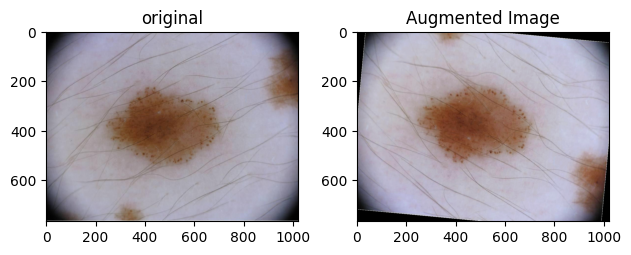

In [31]:
""" For visualizing the usage of all these functions, we use the previous pipeline
for combining them all"""

augmentation_example = transforms.Compose([
    TVRandomHorizontalFlip(p=0.5),
    TVRandomVerticalFlip(p=0.2),
    TVColorJitter(0.15, 0.15, 0.10, 0.02),
    TVSmallRandomRotation(degrees=12),
    TVGaussianBlur(p=0.2, kernel_size=3, sigma=(0.1, 1.0)),
])

fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = augmentation_example(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Augmented Image')
plt.imshow(transformed_sample['image'])

plt.show()

Iterating the dataset
-----------------------------

We can now put everything together to create the train and test datasets with the corresponding transformations.
In summary, every time we sample an image from the dataset (during training):
- We will read the image and the mask
- We will apply the transformations and we will crop the image using a bounding box computed from the mask
- As the final cropping operation is random, we perform data augmentation during sampling

We can easily iterate over the dataset with a ``for i in range`` loop.


In [33]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/LS4_AVCV_DB/dermoscopyDBtrain.csv',
                                    root_dir='data/LS4_AVCV_DB',
                                    maxSize=500, ###IMPORTANT: maxSize=500 to speed-up the training process
                                                 ### Set to 0 or 200 for training your optimal model
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/LS4_AVCV_DB/dermoscopyDBval.csv',
                                    root_dir='data/LS4_AVCV_DB',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/LS4_AVCV_DB/dermoscopyDBtest.csv',
                                    root_dir='data/LS4_AVCV_DB',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(2)
1 torch.Size([3, 224, 224]) tensor(1)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


Finally, we have to create a dataloader allowing to:

- Sample batches of samples to feed the network during training
- Shuffle data
- Load the data in parallel using multiple cores.

``torch.utils.data.DataLoader`` is an iterator that provides all these features. An important parameter of the iterator is ``collate_fn``. We can specify how samples are organized in batches by choosing the most appropriate function. In any case, the default option should work fine in most cases.




0 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2])


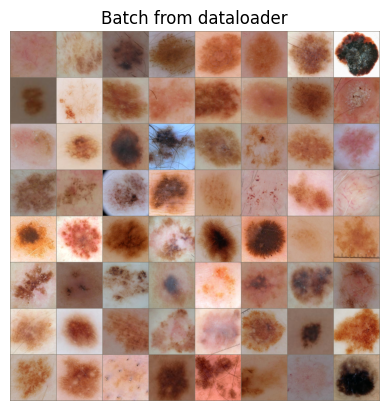

1 torch.Size([64, 3, 224, 224]) tensor([2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


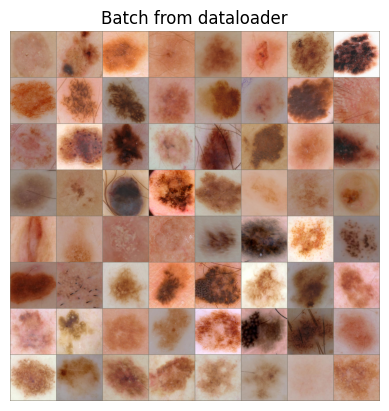

2 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0])


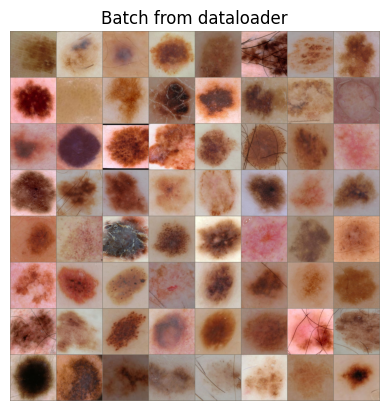

3 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0,
        2, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])


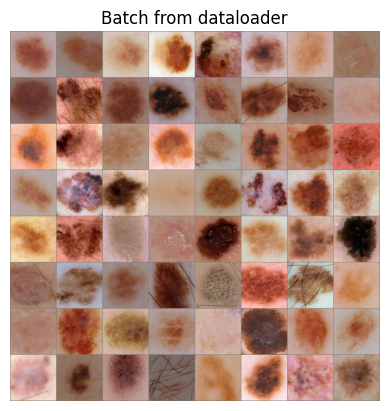

In [35]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 3 workers
#IMPORTANT!!!!! If you plan to run this in a Windows machine, set num_workers=0. Pytorch has a bug on windows
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=0)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=256,
                        shuffle=False, num_workers=0)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers=0)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## Part 2: Design and train a custom diagnosis network
In the second part of the practice we are designing a diagnosis network from scratch. For that end, we next provide a definition of a network which is very similar to LeNet-5, which aims to classifiy input images of size 32x32 px containing digits (MNIST dataset with 10 classes). However, in this case, we are not forced to work with such small images and, indeed, it is highly recommended to user larger sizes (e.g. 224x224 px as it represents the standard size for most well-known networks trained in Imagenet).

In the following cell we provide the skeleton of a network called CustomNet, with the necessary methods: ` __init__` (constructor) and ``forward`` (forward method processes an image and provides a vector with the scores of the 10 classes considered in the problem of digit classification).


In [36]:
#Example network
class CustomNet(nn.Module):
    def __init__(self):
        # In the constructor we will specify those processing blocks which require learnable parameters
        # We just define them to ensure persistence during training, although they will remain disconnected
        # until we define a processing pipeline in forward method.
        super(CustomNet, self).__init__()

        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Maxpooling with kernel 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 2D convolution with 16 input channels, 64 output channels, and 5x5 filters
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully-connected layer which expects an input with 16 channels and a spatial dimension of 5x5 (before flatenning)
        # and produces 120 channels at the output
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully-connected layer which expects an input of 120 channels and produces an output of 84 channels
        self.fc2 = nn.Linear(120, 84)
        # Fully-connected layer which expects an input of 84 channels and produces an output with 10 classes
        self.fc3 = nn.Linear(84, 10)

    #In forward method we connect layers and define the processing pipeline of the network
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Flatten method vectorizes the spatial output of size hxwxchannels into a vector of length h*w*channels
        #by setting the parameter to 1, we start to flatten in dim=1 and do not vectorize the dimension representing
        #the images in the batch
        x = x.flatten(1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)

        return x

#### Exercise:

Modify the previous network and define a CNN that processes a batch of images (e.g. of size 224x224) and computes their outputs with the scores for the 3 classes that we consider in our problem (nevus, melanoma and keratosis).

**IMPORTANT**: The structure of the network must be consistent in order to transform the input tensor  Nx3x224x224 (N the number of images in the batch, 3 the RGB channels, and 224 the spatial dimensions) into the tensor with the scores of each case, with size Nx3 (N the number of images in the batch and 3 the 3 classes of the problem). To do so, you have to adjust the architecture of the previous example, including the number of layers, the strides of each one, etc. so that it transforms the input tensor into the desired final vector. As an aid, the following code is provided that allows you to run the grid over a batch of images and see what the is shape of the output.

In [37]:
import torch.nn.functional as F

class CustomNet(nn.Module):
    def __init__(self):
        # In the constructor, we define the layers with learnable parameters.
        super(CustomNet, self).__init__()

        # --- Convolutional Layers (Feature Extractor) ---
        # These layers are the same as the example, but we'll track
        # how they change the shape of a 224x224 image.

        # Input: (N, 3, 224, 224)
        self.conv1 = nn.Conv2d(3, 6, 5) # -> Output: (N, 6, 220, 220)
        self.pool = nn.MaxPool2d(2, 2)  # -> Output: (N, 6, 110, 110)
        self.conv2 = nn.Conv2d(6, 16, 5) # -> Output: (N, 16, 106, 106)
        # The pool layer is applied again after conv2
        # -> Output after 2nd pool: (N, 16, 53, 53)


        # --- Fully-Connected Layers (Classifier) ---

        # **CHANGE 1: Adjust the input size of the first FC layer**
        # The original code (16 * 5 * 5) was for 32x32 images.
        # For 224x224 images, the output from the conv/pool layers is (16, 53, 53).
        # So, the flattened vector size is 16 * 53 * 53 = 44944.
        self.fc1 = nn.Linear(16 * 53 * 53, 120)

        # This layer is unchanged, it just connects fc1 to fc3
        self.fc2 = nn.Linear(120, 84)

        # **CHANGE 2: Adjust the final output for 3 classes**
        # The original network was for 10 classes (digits).
        # We need 3 classes (nevus, melanoma, keratosis).
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # --- Defines the processing pipeline ---

        # 1. Pass through conv1, apply ReLU, then pool
        x = self.pool(F.relu(self.conv1(x)))

        # 2. Pass through conv2, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))

        # 3. Flatten the 4D tensor (N, C, H, W) to a 2D tensor (N, features)
        # This prepares the data for the fully-connected layers
        x = x.flatten(1) # -> Shape: (N, 44944)

        # **CHANGE 3: Un-comment the FC layers to complete the network**
        x = F.relu(self.fc1(x)) # -> Shape: (N, 120)
        x = F.relu(self.fc2(x)) # -> Shape: (N, 84)
        x = self.fc3(x)         # -> Shape: (N, 3)

        return x



In [38]:
customNet = CustomNet() #we initialize the network
customNet.to(device) #copy the network to the device (gpu)
#Sample a batch of data and get images and labels
data=next(iter(train_dataloader))
inputs = data['image'].to(device).float()
labels = data['label'].to(device)

batchSize = labels.shape
print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = customNet(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([64, 3, 224, 224])
Size of the output tensor is torch.Size([64, 3])


**Hint**: Start commenting all lines in the forward method in except of the first convolutional layer, execute the previous cell and and you will see the shape of the output of that layer. Go uncommenting layer by layer to see the sequential output sizes to decide how many convolutional layers may be adequate and the dimensions of the first fully convolutional layer.

## Part 3: Train and evaluate our CNN

In the third part of the practice we are going to build a first automatic system for the diagnosis of skin lesions based on the network that we have created in the previous section. To train and evaluate the network, we need to define several elements, such as the performance metric, the loss function, the optimizer or the learning rate strategy. In the next sections we will configure these elements.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, and following the instructions of the organizers of the original ISIC challenge, we will use the area under the ROC or AUC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

AUC is a metric that avoids setting a specific threshold to make detections and is applied over the soft outputs of a **binary** classifier. By modifying the value of the threshold, we can build a ROC curve setting the False Positive Rate (FPR) in the y-axis and the True Positive Rate (TPR) in the x-axis. TPR is the proportion of positive cases than have been succesfully detected, whereas FPR is the number of false detections divided by the number of negatives.

For low detection thresholds and an imperfect system, TPR will be high at the expense of a high FPR (as the system always says 1). For high threholds, the opposite situation happens. Once the ROC is built, the AUC measures the integral behind the curve, which is in the range [0,1].

Although, at least theoretically, AUC can be lower than 0.5, in partice, the output of a baseline system that randomly decides 0 or 1 with equal probability obtains an AUC=0.5, so lower values are usually caused by bugs in the code (and could be avoided just by inverting the outputs of the system).

The following figure shows some examples of AUC and ROC curves:


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png' width=384 /></center>

As we have mentioned, AUC is a metric to evaluate binary problems (labels 0,1), and has the advantage of being independent of the detection threshold. It also behaves well against unbalanced problems, as it evaluates the ranking of the scores (their order with respect to the labels) and not their absolute values.

Since our problem is multiclass, we will calculate 3 different AUCs:
- 1) AUC of binary problem melanoma vs all
- 2) AUC of the binary problem seborrheic keratosis vs all
- 3) AUC average of the previous two

The following function computes AUCs from the complete database outputs:



In [44]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores,labels):

    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(int)
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(int)
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)

    return aucs

### Loss function, optimizer, and learning rate strategy

In the next cell we will define the 3 elements we need to train:
- The loss function, which will be a crossed entreopia.
- The optimizer, in which we will use a SGD with momentum, with certain values of lr and momentum
- A learning rate strategy, using a fixed step method, decreasing the lr by a factor of 10, every 7 epochs.


In [42]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Training function

We continue by defining the function that we will use to train our classifier. Note the existence of 3 nested loops:
- Epoch loop: a main loop that goes through training epochs and then allows values to be taken from the evaluation metrics.
- Database loop: the train database is executed first, training the model, and then the validation database, only to obtain outputs and calculate evaluation metrics.
- Loop of iterations: in each iteration the forward, the evaluation of the loss, the backward and the updating of the weights in the optimizer are made.

In [39]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)


                #Batch Size
                batchSize = labels.shape[0]

                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Fine-tuning of a pre-trained CNN
Once we have defined the training and evaluation functions, we will fine-tune AlexNet CNN using our database. In addition, we define the loss, the optimizer and the lr scheduler:

### Specifying the data loaders
Now we are going to assign the dataloaders that we had previously to the arrays of train and val

In [40]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes


### Train your custom network
Finally, we can train the network for several epochs and see the train and validation results.

In [45]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

customNet = train_model(CustomNet(), criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0850 AUC mel: 0.5152 sk: 0.4275 avg: 0.4714
val Loss: 1.0921 AUC mel: 0.4442 sk: 0.4191 avg: 0.4316

Epoch 1/4
----------
train Loss: 1.0851 AUC mel: 0.4969 sk: 0.4651 avg: 0.4810
val Loss: 1.0921 AUC mel: 0.4442 sk: 0.4191 avg: 0.4316

Epoch 2/4
----------
train Loss: 1.0851 AUC mel: 0.5155 sk: 0.4135 avg: 0.4645
val Loss: 1.0921 AUC mel: 0.4442 sk: 0.4191 avg: 0.4316

Epoch 3/4
----------
train Loss: 1.0850 AUC mel: 0.5263 sk: 0.4360 avg: 0.4811
val Loss: 1.0921 AUC mel: 0.4442 sk: 0.4191 avg: 0.4316

Epoch 4/4
----------
train Loss: 1.0847 AUC mel: 0.5348 sk: 0.4494 avg: 0.4921
val Loss: 1.0921 AUC mel: 0.4442 sk: 0.4191 avg: 0.4316

Training complete in 5m 5s
Best model in epoch 0 val AUCs: mel 0.444167 sk 0.419092 avg 0.431629


#### Exercise:

The current code trains the network for 5 epochs using SGD with momentum, with a learning rate strategy and an early stop strategy (taking the epoch that obtains the best results in validation). You can modify this setting by choosing other values ​​for parameters, optimizers, strategies, etc.


In [46]:
### --- Experiment 1: Change Parameters (LR & Weight Decay) --- ###

print("Starting Experiment 1: SGD with higher LR (0.01) and Weight Decay")

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp1 = CustomNet().to(device)

# 2. Define the Optimizer
# CHANGED: lr=1e-3 -> 1e-2, added weight_decay=1e-4
optimizer_exp1 = optim.SGD(model_exp1.parameters(),
                           lr=1e-2,
                           momentum=0.9,
                           weight_decay=1e-4)

# 3. Define the Strategy (same as before)
scheduler_exp1 = lr_scheduler.StepLR(optimizer_exp1, step_size=7, gamma=0.1)

# 4. Run the training
trained_model_exp1 = train_model(model_exp1,
                                 criterion,
                                 optimizer_exp1,
                                 scheduler_exp1,
                                 num_epochs=5)

Starting Experiment 1: SGD with higher LR (0.01) and Weight Decay
Epoch 0/4
----------
train Loss: 0.9648 AUC mel: 0.5211 sk: 0.4857 avg: 0.5034
val Loss: 1.1735 AUC mel: 0.4892 sk: 0.6078 avg: 0.5485

Epoch 1/4
----------
train Loss: 0.8027 AUC mel: 0.4971 sk: 0.6376 avg: 0.5674
val Loss: 1.1658 AUC mel: 0.4333 sk: 0.7588 avg: 0.5961

Epoch 2/4
----------
train Loss: 0.7934 AUC mel: 0.5183 sk: 0.6033 avg: 0.5608
val Loss: 1.1376 AUC mel: 0.6403 sk: 0.5503 avg: 0.5953

Epoch 3/4
----------
train Loss: 0.7639 AUC mel: 0.5856 sk: 0.6749 avg: 0.6303
val Loss: 1.0362 AUC mel: 0.5986 sk: 0.7765 avg: 0.6875

Epoch 4/4
----------
train Loss: 0.7353 AUC mel: 0.6296 sk: 0.7372 avg: 0.6834
val Loss: 0.9956 AUC mel: 0.7050 sk: 0.7200 avg: 0.7125

Training complete in 5m 4s
Best model in epoch 4 val AUCs: mel 0.705000 sk 0.720018 avg 0.712509


In [47]:
### --- Experiment 2: Change Optimizer (Adam) --- ###

print("\nStarting Experiment 2: Using Adam Optimizer")

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp2 = CustomNet().to(device)

# 2. Define the Optimizer
# CHANGED: Replaced optim.SGD with optim.Adam
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=1e-3)

# 3. Define the Strategy (same as before, to isolate the optimizer change)
scheduler_exp2 = lr_scheduler.StepLR(optimizer_exp2, step_size=7, gamma=0.1)

# 4. Run the training
trained_model_exp2 = train_model(model_exp2,
                                 criterion,
                                 optimizer_exp2,
                                 scheduler_exp2,
                                 num_epochs=5)


Starting Experiment 2: Using Adam Optimizer
Epoch 0/4
----------
train Loss: 1.0639 AUC mel: 0.5597 sk: 0.5688 avg: 0.5643
val Loss: 1.0934 AUC mel: 0.4375 sk: 0.4945 avg: 0.4660

Epoch 1/4
----------
train Loss: 0.9073 AUC mel: 0.5148 sk: 0.5310 avg: 0.5229
val Loss: 1.0350 AUC mel: 0.4728 sk: 0.7901 avg: 0.6315

Epoch 2/4
----------
train Loss: 0.7803 AUC mel: 0.5525 sk: 0.6666 avg: 0.6095
val Loss: 1.0908 AUC mel: 0.7133 sk: 0.7381 avg: 0.7257

Epoch 3/4
----------
train Loss: 0.7429 AUC mel: 0.6010 sk: 0.7209 avg: 0.6610
val Loss: 1.0253 AUC mel: 0.6650 sk: 0.7235 avg: 0.6943

Epoch 4/4
----------
train Loss: 0.7046 AUC mel: 0.6722 sk: 0.7722 avg: 0.7222
val Loss: 0.9819 AUC mel: 0.6931 sk: 0.6299 avg: 0.6615

Training complete in 5m 6s
Best model in epoch 2 val AUCs: mel 0.713333 sk 0.738095 avg 0.725714


In [48]:
### --- Experiment 3: Change Parameters (LR, Weight Decay, epochs) --- ###

print("Starting Experiment 1: SGD with higher LR (0.01), Weight Decay and 7 epochs")

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp1 = CustomNet().to(device)

# 2. Define the Optimizer
# CHANGED: lr=1e-3 -> 1e-2, added weight_decay=1e-4
optimizer_exp1 = optim.SGD(model_exp1.parameters(),
                           lr=1e-2,
                           momentum=0.9,
                           weight_decay=1e-4)

# 3. Define the Strategy (same as before)
scheduler_exp1 = lr_scheduler.StepLR(optimizer_exp1, step_size=7, gamma=0.1)

# 4. Run the training
trained_model_exp1 = train_model(model_exp1,
                                 criterion,
                                 optimizer_exp1,
                                 scheduler_exp1,
                                 num_epochs=7)

Starting Experiment 1: SGD with higher LR (0.01), Weight Decay and 7 epochs
Epoch 0/6
----------
train Loss: 0.9648 AUC mel: 0.5211 sk: 0.4857 avg: 0.5034
val Loss: 1.1735 AUC mel: 0.4892 sk: 0.6078 avg: 0.5485

Epoch 1/6
----------
train Loss: 0.8027 AUC mel: 0.4971 sk: 0.6376 avg: 0.5674
val Loss: 1.1658 AUC mel: 0.4333 sk: 0.7588 avg: 0.5961

Epoch 2/6
----------
train Loss: 0.7934 AUC mel: 0.5183 sk: 0.6033 avg: 0.5608
val Loss: 1.1376 AUC mel: 0.6403 sk: 0.5503 avg: 0.5953

Epoch 3/6
----------
train Loss: 0.7639 AUC mel: 0.5856 sk: 0.6749 avg: 0.6303
val Loss: 1.0362 AUC mel: 0.5986 sk: 0.7765 avg: 0.6875

Epoch 4/6
----------
train Loss: 0.7353 AUC mel: 0.6296 sk: 0.7372 avg: 0.6834
val Loss: 0.9956 AUC mel: 0.7050 sk: 0.7200 avg: 0.7125

Epoch 5/6
----------
train Loss: 0.7312 AUC mel: 0.6643 sk: 0.6893 avg: 0.6768
val Loss: 1.0027 AUC mel: 0.7000 sk: 0.7050 avg: 0.7025

Epoch 6/6
----------
train Loss: 0.7231 AUC mel: 0.6597 sk: 0.7339 avg: 0.6968
val Loss: 0.9659 AUC mel: 0.6

#### Exercise

The current code trains the network for 5 epochs and then returns the model that obtains the best results in validation (measured through the AUC). It could be necessary, in case the training times are long and you work with Google Colab (with limits on the duration of the session), to implement a save-and-resume strategy that allows you to train models through different sessions . You can find details on how to do it at:

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

In [73]:
import os.path # <-- You'll need this to check if the checkpoint file exists

#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model2(model, criterion, optimizer, scheduler, num_epochs=25, checkpoint_path='training_checkpoint.pth'):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    # --- MODIFIED: Load checkpoint if it exists ---
    start_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    if os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_auc = checkpoint['best_auc']
        best_model_wts = checkpoint['best_model_wts']
        best_epoch = checkpoint['best_epoch']
        print(f"Resumed from epoch {start_epoch}. Best AUC so far: {best_auc:.4f}")
    else:
        print(f"No checkpoint found at {checkpoint_path}. Starting new training.")
    # --- End of modification ---

    #Loop of epochs (each iteration involves train and val datasets)
    # --- MODIFIED: Start from 'start_epoch' ---
    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)

            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0
            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)

                #Batch Size
                batchSize = labels.shape[0]
                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        # --- NEW: Save checkpoint at the end of each epoch ---
        print(f"Saving checkpoint to {checkpoint_path}")
        torch.save({
            'epoch': epoch + 1,  # Save the *next* epoch number to start from
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_auc': best_auc,
            'best_model_wts': best_model_wts,
            'best_epoch': best_epoch
        }, checkpoint_path)
        # --- End of new section ---

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [52]:
# We fix seeds for reproducibility (only matters for the *first* run)
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# --- Define your model, optimizer, etc. ---
# IMPORTANT: You must create the model and optimizer
# *before* calling train_model, so they can be
# populated with the checkpoint data if it exists.

customNet = CustomNet().to(device) # Or ResNet, VGG, etc.

# Use your original optimizer and scheduler setup
optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# --- Define the checkpoint path ---
CHECKPOINT_FILE = 'my_customnet_checkpoint.pth'

# --- Run the training ---
# 1st run: Will say "No checkpoint found" and train 5 epochs.
# 2nd run: Will say "Resuming training" and load the file.
customNet = train_model2(customNet,
                        criterion,
                        optimizer_ft,
                        exp_lr_scheduler,
                        num_epochs=7,  # Total epochs you want to have run
                        checkpoint_path=CHECKPOINT_FILE)

Resuming training from checkpoint: my_customnet_checkpoint.pth
Resumed from epoch 2. Best AUC so far: 0.5158
Epoch 2/6
----------


KeyboardInterrupt: 

## Part 4: Fine-tuning a pre-trained model

Now, instead of training a CNN designed by us from the beginning, we are going to do a fine-tuning of a network that has previously been trained for another task. As seen in theory, this is usually a good alternative when there is not a large amount of data to train (in proportion to the parameters to be learned).

In particular, we are going to use the Alexnet CNN network, included in the ``torchvision`` package, with the weights that have been pre-trained in Imagenet.

The difference between both cases is that ImageNet has 1000 categories of objects and our database has 3 (nevus, melanoma and seborrheic keratosis). Therefore, we will be able to reuse the entire network except the last layer, where the dimensions will be different from our problem. Therefore, once we load the model, we will overwrite the last layer with a new one, with randomly initialized weights, that meets the dimensions of our database.


In [53]:
# Load the model => With pretrained=True we load the optimal weights for ImageNet,
# a dataset that has 1000 object categories => We do fine-tuning for our problem with 3 clases
ftNet = models.alexnet(pretrained=True)
#Print model structure
print(ftNet)
#Get the number of features of the last hidden layer
num_ftrs = ftNet.classifier[6].in_features
# Adjust the last layer to produce scores for 3 classes
# Generate a new layer that substitutes the old one
num_classes = len(train_dataset.classes)
ftNet.classifier[6] = nn.Linear(num_ftrs,num_classes)
# Show again the structure of the model with the modifications
print(ftNet)
ftNet = ftNet.to(device)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 150MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Re-define the optimizer for the new network
The previous one was used on the customNet parameters, so we have to define a new one on the new network.

In [54]:
# SGD with momentum
optimizer_ft = optim.SGD(ftNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train

In [55]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

ftNet = train_model(ftNet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0257 AUC mel: 0.4865 sk: 0.5115 avg: 0.4990
val Loss: 0.9437 AUC mel: 0.6825 sk: 0.7714 avg: 0.7269

Epoch 1/4
----------
train Loss: 0.7171 AUC mel: 0.6774 sk: 0.7878 avg: 0.7326
val Loss: 0.9453 AUC mel: 0.6797 sk: 0.7522 avg: 0.7160

Epoch 2/4
----------
train Loss: 0.6525 AUC mel: 0.7311 sk: 0.7893 avg: 0.7602
val Loss: 1.0323 AUC mel: 0.6886 sk: 0.7526 avg: 0.7206

Epoch 3/4
----------
train Loss: 0.6007 AUC mel: 0.7907 sk: 0.8355 avg: 0.8131
val Loss: 0.8639 AUC mel: 0.6664 sk: 0.7791 avg: 0.7227

Epoch 4/4
----------
train Loss: 0.5762 AUC mel: 0.8077 sk: 0.8521 avg: 0.8299
val Loss: 0.9028 AUC mel: 0.6928 sk: 0.8199 avg: 0.7563

Training complete in 8m 27s
Best model in epoch 4 val AUCs: mel 0.692778 sk 0.819885 avg 0.756332


#### Exercise

The current solution uses Alexnet pre-trained on ImageNet and then fine-tunes it for our particular problem. You can try other networks, many of which come pre-trained in the ``torchvision`` package. For this, it is always necessary to adapt the last layers to our database, generating 3-position outputs. You can find a guide at:

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In addition to the torchvision models, github and other repositories also have very competitive networks that could be useful.



In [56]:
### --- Option 1: Train ResNet18 --- ###
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

def setup_resnet18():
    """
    Loads a pre-trained ResNet18 model and adapts its
    final layer for 3-class classification.
    """
    # 1. Load the pre-trained model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 2. Freeze all pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace the final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

# 1. Set up the model
model_resnet = setup_resnet18()
model_resnet = model_resnet.to(device)

# 2. Set up the Optimizer (to update ONLY the new layer)
print("--- Training ResNet18 ---")
print("Parameters to train:")
params_to_update = []
for name, param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer_resnet = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)

# 3. Set up the scheduler
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

# 4. Run the training
# (Assumes train_model, criterion are defined)
trained_resnet = train_model(model_resnet,
                             criterion,
                             optimizer_resnet,
                             scheduler_resnet,
                             num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


--- Training ResNet18 ---
Parameters to train:
	 fc.weight
	 fc.bias
Epoch 0/4
----------
train Loss: 0.9428 AUC mel: 0.5345 sk: 0.4429 avg: 0.4887
val Loss: 1.4405 AUC mel: 0.5528 sk: 0.4374 avg: 0.4951

Epoch 1/4
----------
train Loss: 0.8724 AUC mel: 0.5312 sk: 0.5170 avg: 0.5241
val Loss: 1.1110 AUC mel: 0.6008 sk: 0.5456 avg: 0.5732

Epoch 2/4
----------
train Loss: 0.7708 AUC mel: 0.6633 sk: 0.6068 avg: 0.6351
val Loss: 1.0918 AUC mel: 0.6417 sk: 0.6292 avg: 0.6354

Epoch 3/4
----------
train Loss: 0.7389 AUC mel: 0.6979 sk: 0.7000 avg: 0.6990
val Loss: 1.0003 AUC mel: 0.6847 sk: 0.6953 avg: 0.6900

Epoch 4/4
----------
train Loss: 0.6949 AUC mel: 0.7459 sk: 0.7805 avg: 0.7632
val Loss: 0.9685 AUC mel: 0.7256 sk: 0.7385 avg: 0.7320

Training complete in 9m 43s
Best model in epoch 4 val AUCs: mel 0.725556 sk 0.738536 avg 0.732046


In [ ]:
### --- Option 2: Train VGG16 --- ###
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

def setup_vgg16():
    """
    Loads a pre-trained VGG16 model and adapts its
    final layer for 3-class classification.
    """
    # 1. Load the pre-trained model
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # 2. Freeze the 'features' (convolutional layers)
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Replace the final layer (at index 6 of the classifier)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 3)
    return model

# 1. Set up the model
model_vgg = setup_vgg16()
model_vgg = model_vgg.to(device)

# 2. Set up the Optimizer (to update ONLY the new layers)
print("--- Training VGG16 ---")
print("Parameters to train:")
params_to_update = []
for name, param in model_vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

# Note: VGG's classifier layers are trainable by default
optimizer_vgg = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)

# 3. Set up the scheduler
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

# 4. Run the training
# (Assumes train_model, criterion are defined)
trained_vgg = train_model(model_vgg,
                          criterion,
                          optimizer_vgg,
                          scheduler_vgg,
                          num_epochs=5)

## Part 5: Evaluation (Important)
The evaluation of this practice will be done through a challenge, for which the students will have to send the results based on the test data in two categories:

- 1) CUSTOM Category: The results on the test set of a custom network, created from scratch by the students. In this case, the complete code of the network must appear in cells of the notebook and it will not be possible to make use of external networks/packages or pre-trained models.

- 2) FINE-TUNING Category: The results on the test set of a network that has been previously initialized in another database (with fine-tuning). In this case, existing models in torchvision or even external networks can be used.

In addition, the final mark will depend both on the results in both categories and on the content of a brief report (1 side for the description, 1 side for extra material: tables, figures and references) where they will describe the most important aspects of the proposed solutions. The objective of this report is for the teacher to assess the developments/extensions/decisions made by the students when optimizing their system. You do not need to provide an absolute level of detail about the changes made, just list them and briefly discuss the purpose of the changes.

### Details of the material to send for evaluation:

One zip file will be uploaded per group with the following contents:

- Two .csv files with the test outputs of the models that have trained in the two categories. Each file will contain a matrix of size 600x3, 600 lesions and the 3 classes considered in the problem. The array should be provided in csv format (with 3 numbers per row separated by ','). Code to generate the outputs is provided later.

- The report as described above.

- The notebook that integrates the creation of both models so that the teacher can check how things have been implemented.

**The deadline for submission of your results + the report is Friday Oct 31 at 23:59.**


Next we provide some functions that allow to test the network and create the csv file with the outputs.


In [60]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()

    numClasses = len(test_dataset.classes)

    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)

    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=float)
    labels_m=np.zeros((numSamples,),dtype=int)
    contSamples=0

    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()


        #Tamaño del batch
        batchSize = inputs.shape[0]

        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize


    return outputs_m

Running the previous function and obtaining the matrix with the scores (Nx3)

And finally save the matrix into a csv file

Model 1 (from Scratch)

In [57]:
# Starting with a copy of CustomNet

class ScratchNet(nn.Module):
    def __init__(self):
        # In the constructor, we define the layers with learnable parameters.
        super(ScratchNet, self).__init__()

        # --- Convolutional Layers (Feature Extractor) ---
        # These layers are the same as the example, but we'll track
        # how they change the shape of a 224x224 image.

        # Input: (N, 3, 224, 224)
        self.conv1 = nn.Conv2d(3, 6, 5) # -> Output: (N, 6, 220, 220)
        self.pool = nn.MaxPool2d(2, 2)  # -> Output: (N, 6, 110, 110)
        self.conv2 = nn.Conv2d(6, 16, 5) # -> Output: (N, 16, 106, 106)
        # The pool layer is applied again after conv2
        # -> Output after 2nd pool: (N, 16, 53, 53)


        # --- Fully-Connected Layers (Classifier) ---

        # **CHANGE 1: Adjust the input size of the first FC layer**
        # The original code (16 * 5 * 5) was for 32x32 images.
        # For 224x224 images, the output from the conv/pool layers is (16, 53, 53).
        # So, the flattened vector size is 16 * 53 * 53 = 44944.
        self.fc1 = nn.Linear(16 * 53 * 53, 120)

        # This layer is unchanged, it just connects fc1 to fc3
        self.fc2 = nn.Linear(120, 84)

        # **CHANGE 2: Adjust the final output for 3 classes**
        # The original network was for 10 classes (digits).
        # We need 3 classes (nevus, melanoma, keratosis).
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # --- Defines the processing pipeline ---

        # 1. Pass through conv1, apply ReLU, then pool
        x = self.pool(F.relu(self.conv1(x)))

        # 2. Pass through conv2, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))

        # 3. Flatten the 4D tensor (N, C, H, W) to a 2D tensor (N, features)
        # This prepares the data for the fully-connected layers
        x = x.flatten(1) # -> Shape: (N, 44944)

        x = F.relu(self.fc1(x)) # -> Shape: (N, 120)
        x = F.relu(self.fc2(x)) # -> Shape: (N, 84)
        x = self.fc3(x)         # -> Shape: (N, 3)

        return x

In [62]:
# We train the model using Adam optimizer

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp1 = ScratchNet().to(device)

# 2. Define the Optimizer
# CHANGED: Replaced optim.SGD with optim.Adam
optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=1e-3)

# 3. Define the Strategy (same as before, to isolate the optimizer change)
scheduler_exp1 = lr_scheduler.StepLR(optimizer_exp1, step_size=7, gamma=0.1)

# 4. Run the training
trained_model_exp1 = train_model(model_exp1,
                                 criterion,
                                 optimizer_exp1,
                                 scheduler_exp1,
                                 num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0639 AUC mel: 0.5597 sk: 0.5688 avg: 0.5643
val Loss: 1.0934 AUC mel: 0.4375 sk: 0.4945 avg: 0.4660

Epoch 1/4
----------
train Loss: 0.9073 AUC mel: 0.5148 sk: 0.5310 avg: 0.5229
val Loss: 1.0350 AUC mel: 0.4728 sk: 0.7901 avg: 0.6315

Epoch 2/4
----------
train Loss: 0.7803 AUC mel: 0.5525 sk: 0.6666 avg: 0.6095
val Loss: 1.0908 AUC mel: 0.7133 sk: 0.7381 avg: 0.7257

Epoch 3/4
----------
train Loss: 0.7429 AUC mel: 0.6010 sk: 0.7209 avg: 0.6610
val Loss: 1.0253 AUC mel: 0.6650 sk: 0.7235 avg: 0.6943

Epoch 4/4
----------
train Loss: 0.7046 AUC mel: 0.6722 sk: 0.7722 avg: 0.7222
val Loss: 0.9819 AUC mel: 0.6931 sk: 0.6299 avg: 0.6615

Training complete in 5m 6s
Best model in epoch 2 val AUCs: mel 0.713333 sk 0.738095 avg 0.725714


In [63]:
# Change the LR scheduler to cosine

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp2 = ScratchNet().to(device)

# 2. Define the Optimizer
# CHANGED: Replaced optim.SGD with optim.Adam
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=1e-3, weight_decay=1e-4)

# 3. Define the Strategy (same as before, to isolate the optimizer change)
scheduler_exp2 = lr_scheduler.CosineAnnealingLR(optimizer_exp2, T_max=5)

# 4. Run the training
trained_model_exp2 = train_model(model_exp2,
                                 criterion,
                                 optimizer_exp2,
                                 scheduler_exp2,
                                 num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0435 AUC mel: 0.5509 sk: 0.5695 avg: 0.5602
val Loss: 1.0323 AUC mel: 0.4500 sk: 0.6951 avg: 0.5726

Epoch 1/4
----------
train Loss: 0.9390 AUC mel: 0.5198 sk: 0.5237 avg: 0.5218
val Loss: 0.9696 AUC mel: 0.5081 sk: 0.7923 avg: 0.6502

Epoch 2/4
----------
train Loss: 0.7851 AUC mel: 0.5693 sk: 0.6316 avg: 0.6004
val Loss: 1.0970 AUC mel: 0.6278 sk: 0.7851 avg: 0.7064

Epoch 3/4
----------
train Loss: 0.7532 AUC mel: 0.6090 sk: 0.6910 avg: 0.6500
val Loss: 1.0283 AUC mel: 0.7044 sk: 0.7851 avg: 0.7447

Epoch 4/4
----------
train Loss: 0.7402 AUC mel: 0.6327 sk: 0.7111 avg: 0.6719
val Loss: 1.0243 AUC mel: 0.7028 sk: 0.7791 avg: 0.7409

Training complete in 5m 9s
Best model in epoch 3 val AUCs: mel 0.704444 sk 0.785053 avg 0.744749


In [65]:
# Change the LR scheduler to cosine

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
model_exp3 = ScratchNet().to(device)

# 2. Define the Optimizer
# CHANGED: Replaced optim.SGD with optim.Adam
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=1e-3, weight_decay=1e-4)

# 3. Define the Strategy (same as before, to isolate the optimizer change)
scheduler_exp3 = lr_scheduler.CosineAnnealingLR(optimizer_exp3, T_max=5)

# 4. Run the training
trained_model_exp3 = train_model2(model_exp3,
                                 criterion,
                                 optimizer_exp3,
                                 scheduler_exp3,
                                 num_epochs=7)

Epoch 0/6
----------
train Loss: 1.0435 AUC mel: 0.5509 sk: 0.5695 avg: 0.5602
val Loss: 1.0323 AUC mel: 0.4500 sk: 0.6951 avg: 0.5726

Epoch 1/6
----------
train Loss: 0.9390 AUC mel: 0.5198 sk: 0.5237 avg: 0.5218
val Loss: 0.9696 AUC mel: 0.5081 sk: 0.7923 avg: 0.6502

Epoch 2/6
----------
train Loss: 0.7851 AUC mel: 0.5693 sk: 0.6316 avg: 0.6004
val Loss: 1.0970 AUC mel: 0.6278 sk: 0.7851 avg: 0.7064

Epoch 3/6
----------
train Loss: 0.7532 AUC mel: 0.6090 sk: 0.6910 avg: 0.6500
val Loss: 1.0283 AUC mel: 0.7044 sk: 0.7851 avg: 0.7447

Epoch 4/6
----------
train Loss: 0.7402 AUC mel: 0.6327 sk: 0.7111 avg: 0.6719
val Loss: 1.0243 AUC mel: 0.7028 sk: 0.7791 avg: 0.7409

Epoch 5/6
----------
train Loss: 0.7396 AUC mel: 0.6278 sk: 0.7124 avg: 0.6701
val Loss: 1.0243 AUC mel: 0.7028 sk: 0.7791 avg: 0.7409

Epoch 6/6
----------
train Loss: 0.7364 AUC mel: 0.6353 sk: 0.7182 avg: 0.6768
val Loss: 1.0275 AUC mel: 0.6942 sk: 0.7811 avg: 0.7376

Training complete in 7m 26s
Best model in epoch 

In [66]:
import csv

outputs1=test_model(trained_model_exp2)

with open('output1_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs1);

print(outputs1)

[[0.72091144 0.18802799 0.09106057]
 [0.72879702 0.237369   0.03383397]
 [0.47923303 0.4526386  0.06812838]
 ...
 [0.73748547 0.17821135 0.08430318]
 [0.71494532 0.21946456 0.0655901 ]
 [0.86305022 0.1112872  0.02566259]]


# **Fine-Tuning an Existing Network**

In [67]:
# We start with standard Alexnet CNN as we tried before and got the best result

# SGD with momentum
optimizer_ft = optim.SGD(ftNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

ftNet = train_model(ftNet, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5329 AUC mel: 0.8437 sk: 0.8826 avg: 0.8632
val Loss: 0.8647 AUC mel: 0.7033 sk: 0.7844 avg: 0.7439

Epoch 1/4
----------
train Loss: 0.4907 AUC mel: 0.8789 sk: 0.9231 avg: 0.9010
val Loss: 0.9514 AUC mel: 0.7053 sk: 0.7897 avg: 0.7475

Epoch 2/4
----------
train Loss: 0.4723 AUC mel: 0.8947 sk: 0.9242 avg: 0.9095
val Loss: 0.9049 AUC mel: 0.7064 sk: 0.8287 avg: 0.7675

Epoch 3/4
----------
train Loss: 0.4406 AUC mel: 0.9009 sk: 0.9430 avg: 0.9220
val Loss: 0.9271 AUC mel: 0.7258 sk: 0.8159 avg: 0.7709

Epoch 4/4
----------
train Loss: 0.4318 AUC mel: 0.9075 sk: 0.9436 avg: 0.9255
val Loss: 0.8466 AUC mel: 0.7253 sk: 0.8585 avg: 0.7919

Training complete in 8m 33s
Best model in epoch 4 val AUCs: mel 0.725278 sk 0.858466 avg 0.791872


In [68]:
# --- Proposal 1: Use AdamW (Adam with Weight Decay) ---

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
ftNet2 = ftNet

# 2. CHANGED: Define the Optimizer as Adam
# We use a common learning rate (1e-3) and add weight decay (1e-4)
optimizer_ft_adam = optim.Adam(ftNet2.parameters(), lr=1e-3, weight_decay=1e-4)

# 3. Define the Strategy (we can keep the same one)
scheduler_adam = lr_scheduler.StepLR(optimizer_ft_adam, step_size=7, gamma=0.1)

# 4. Run the training
ftNet_adam = train_model(ftNet2,
                         criterion,
                         optimizer_ft_adam,
                         scheduler_adam,
                         num_epochs=5)

Epoch 0/4
----------
train Loss: 3.4959 AUC mel: 0.6037 sk: 0.5529 avg: 0.5783
val Loss: 1.0502 AUC mel: 0.5442 sk: 0.6457 avg: 0.5949

Epoch 1/4
----------
train Loss: 0.8373 AUC mel: 0.5060 sk: 0.5173 avg: 0.5116
val Loss: 1.2443 AUC mel: 0.6329 sk: 0.3787 avg: 0.5058

Epoch 2/4
----------
train Loss: 0.7959 AUC mel: 0.5051 sk: 0.3991 avg: 0.4521
val Loss: 1.1754 AUC mel: 0.5000 sk: 0.5000 avg: 0.5000

Epoch 3/4
----------
train Loss: 0.7930 AUC mel: 0.5062 sk: 0.4564 avg: 0.4813
val Loss: 1.1382 AUC mel: 0.5000 sk: 0.5000 avg: 0.5000

Epoch 4/4
----------


KeyboardInterrupt: 

In [70]:
# --- Proposal 1: Use AdamW with Cosine Scheduler ---

# We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# 1. Instantiate the model
ftNet3 = ftNet

# 2. CHANGED: Define the Optimizer as Adam
# We use a common learning rate (1e-3) and add weight decay (1e-4)
optimizer_ft_adam = optim.Adam(ftNet2.parameters(), lr=1e-3, weight_decay=1e-4)

# 3. Define the Strategy (we can keep the same one)
scheduler_adam = lr_scheduler.CosineAnnealingLR(optimizer_ft_adam, T_max=5)

# 4. Run the training
ftNet_adam2 = train_model(ftNet3,
                         criterion,
                         optimizer_ft_adam,
                         scheduler_adam,
                         num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7950 AUC mel: 0.5510 sk: 0.5525 avg: 0.5517
val Loss: 1.1276 AUC mel: 0.5000 sk: 0.5000 avg: 0.5000

Epoch 1/4
----------
train Loss: 0.8068 AUC mel: 0.5019 sk: 0.6027 avg: 0.5523
val Loss: 1.1746 AUC mel: 0.6167 sk: 0.4478 avg: 0.5322

Epoch 2/4
----------
train Loss: 0.7739 AUC mel: 0.6271 sk: 0.6568 avg: 0.6419
val Loss: 1.0938 AUC mel: 0.5411 sk: 0.6909 avg: 0.6160

Epoch 3/4
----------
train Loss: 0.7851 AUC mel: 0.5486 sk: 0.5553 avg: 0.5519
val Loss: 1.2025 AUC mel: 0.6261 sk: 0.3534 avg: 0.4898

Epoch 4/4
----------
train Loss: 0.7840 AUC mel: 0.5586 sk: 0.5187 avg: 0.5387
val Loss: 1.1547 AUC mel: 0.6642 sk: 0.3810 avg: 0.5226

Training complete in 9m 16s
Best model in epoch 2 val AUCs: mel 0.541111 sk 0.690917 avg 0.616014


In [79]:
def train_model3(model, criterion, optimizer, scheduler, num_epochs=25, checkpoint_path='training_checkpoint.pth'):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    # --- MODIFIED: Load checkpoint if it exists ---
    start_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    if os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_auc = checkpoint['best_auc']
        best_model_wts = checkpoint['best_wts'] # Corrected key
        best_epoch = checkpoint['best_epoch']
        print(f"Resumed from epoch {start_epoch}. Best AUC so far: {best_auc:.4f}")
    else:
        print(f"No checkpoint found at {checkpoint_path}. Starting new training.")
    # --- End of modification ---

    #Loop of epochs (each iteration involves train and val datasets)
    # --- MODIFIED: Start from 'start_epoch' ---
    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)

            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0
            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)

                #Batch Size
                batchSize = labels.shape[0]
                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize


            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val':
                # --- NEW: Step the scheduler with the validation metric ---
                scheduler.step(epoch_auc)
                # --- End of new section ---
                if epoch_auc > best_auc:
                    best_auc = epoch_auc
                    best_aucs = aucs.copy()
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch

        # --- NEW: Save checkpoint at the end of each epoch ---
        print(f"Saving checkpoint to {checkpoint_path}")
        torch.save({
            'epoch': epoch + 1,  # Save the *next* epoch number to start from
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_auc': best_auc,
            'best_model_wts': best_model_wts,
            'best_epoch': best_epoch
        }, checkpoint_path)
        # --- End of new section ---

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [80]:
# We start with standard Alexnet CNN as we tried before and got the best result

# SGD with momentum
optimizer_ft2 = optim.SGD(ftNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, # Corrected optimizer to optimizer_ft2
                                                  mode='max',
                                                  factor=0.1,
                                                  patience=2)

#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

ftNet2 = train_model3(ftNet, criterion, optimizer_ft2, exp_lr_scheduler2,
                    num_epochs=5)

No checkpoint found at training_checkpoint.pth. Starting new training.
Epoch 0/4
----------
train Loss: 0.7415 AUC mel: 0.8805 sk: 0.8651 avg: 0.8728
val Loss: 1.1944 AUC mel: 0.5142 sk: 0.3380 avg: 0.4261
Saving checkpoint to training_checkpoint.pth

Epoch 1/4
----------
train Loss: 0.7585 AUC mel: 0.8223 sk: 0.8319 avg: 0.8271
val Loss: 1.1609 AUC mel: 0.6550 sk: 0.3565 avg: 0.5057
Saving checkpoint to training_checkpoint.pth

Epoch 2/4
----------
train Loss: 0.7639 AUC mel: 0.8410 sk: 0.8290 avg: 0.8350
val Loss: 1.1578 AUC mel: 0.4911 sk: 0.6609 avg: 0.5760
Saving checkpoint to training_checkpoint.pth

Epoch 3/4
----------
train Loss: 0.7762 AUC mel: 0.6654 sk: 0.6719 avg: 0.6687
val Loss: 1.1558 AUC mel: 0.6714 sk: 0.4059 avg: 0.5386
Saving checkpoint to training_checkpoint.pth

Epoch 4/4
----------
train Loss: 0.7847 AUC mel: 0.5269 sk: 0.5356 avg: 0.5312
val Loss: 1.1631 AUC mel: 0.5836 sk: 0.3543 avg: 0.4689
Saving checkpoint to training_checkpoint.pth

Training complete in 10m